# Read the Data

These lines read in the pickle files with simulation data into pandas data frames

In [19]:
import gzip
import pickle
import pandas as pd
import numpy as np

YSE_FILTERS = 'grizXY' # XY are the ZTF g and r bands, respectively

explosiondict = {605: -8.0, 604: -7.0, 607: -8.0, 606: -6.1,
                601: -15.1, 603: -38.0, 602: -40.1, 612: -9.1,
                613: -6.1, 610: -16.1, 611: -12.1, 609: -14.1,
                608: -42.1, 614: -17.0, 617: -14.0, 618: -19.1,
                620: -94.1, 621: -64.0, 616: -10.0, 619: -15.1,
                0:-15, 615:-13}

def read_data(filename):
    """Read data from pickled file to a pandas dataframe"""
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)

    X = to_dataframe(data)
    y = pd.get_dummies(X.type == 0, prefix='SNIa', drop_first=True)
    X = X.drop(columns=['type'])

    return X, y


def to_dataframe(data):
    """Converts from a python dictionary to a pandas dataframe"""
    for idx in data:
        sn = data[idx]
        for filt in YSE_FILTERS:
            sn['mjd_%s' % filt] = np.array(sn[filt]['mjd'])
            sn['fluxcal_%s' % filt] = np.array(sn[filt]['fluxcal'])
            sn['fluxcalerr_%s' % filt] = np.array(sn[filt]['fluxcalerr'])
            sn['days_from_explosion_%s' % filt] = \
                sn['mjd_%s' % filt] - sn['header']['SIM_PEAKMJD'] - explosiondict[sn['header']['SIM_NON1a']]
            del sn[filt]
        sn.update(sn['header'])
        del sn['header']

    return pd.DataFrame.from_dict(data, orient='index')

Now you can read the data using the following line.  These are pretty big files, reading them in is slow.  I can try to condense them in the future...Or maybe there's a way to refactor the code that reads them in

In [20]:
X, y = read_data('yse_ztf_YOUNG.pkl.gz')

The X contain the data itself. You can take a look at what IDs are present in X by using

In [ ]:
X.index[:100]

In [4]:
# Get one supernovae - the first in the list
X.iloc[0]

mjd_g                  [59353.0, 59359.0, 59362.0, 59365.0, 59371.0, ...
fluxcal_g              [233.8984, 501.2598, 265.6817, -288.73492, -71...
fluxcalerr_g           [417.01376, 366.80484, 190.09012, 242.42026, 4...
mjd_r                  [59353.0, 59359.0, 59362.0, 59365.0, 59371.0, ...
fluxcal_r              [2.517171, -22.713633, -3.452587, 106.43792, -...
fluxcalerr_r           [82.971855, 77.636856, 47.37482, 55.71112, 82....
mjd_i                  [59353.0, 59359.0, 59362.0, 59365.0, 59371.0, ...
fluxcal_i              [-4.467447, -110.264366, 43.4474, -88.54981, 1...
fluxcalerr_i           [114.44972, 107.47198, 76.1148, 62.37235, 121....
mjd_z                  [59353.0, 59359.0, 59362.0, 59365.0, 59371.0, ...
fluxcal_z              [114.628204, -62.237488, 110.33769, 4.368852, ...
fluxcalerr_z           [170.86844, 142.80426, 130.26945, 98.79998, 16...
mjd_X                  [59352.88, 59355.88, 59358.88, 59364.88, 59367...
fluxcal_X              [142.11076, -85.87944, 147.1

# Plot the Lightcurves

You can use the utility bellow to plot one (or a few) light curves

In [5]:
#Plot the data
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

YSE_FILTERS = 'grizXY'

def plot_lightcurves(idx, X):    
    
    flux = []
    for f in YSE_FILTERS:
        if len(X.iloc[idx]['fluxcal_' + f]) > 0:
            flux.append(max(X.iloc[idx]['fluxcal_' + f]))
            
    for id_f, f in enumerate(YSE_FILTERS):
        
        
        ax = axes[id_f // 3, id_f % 3]
        ax.errorbar(X.iloc[idx]['mjd_%s' % f] - X.iloc[idx]['pkmjd'], 
                    X.iloc[idx]['fluxcal_%s' % f]/max(flux), 
                    X.iloc[idx]['fluxcalerr_%s' % f]/max(flux), 
                    fmt='o')
        ax.set_xlabel('MJD')
        ax.set_ylabel('Calibrated flux')
        ax.set_title('%s-band' % f)

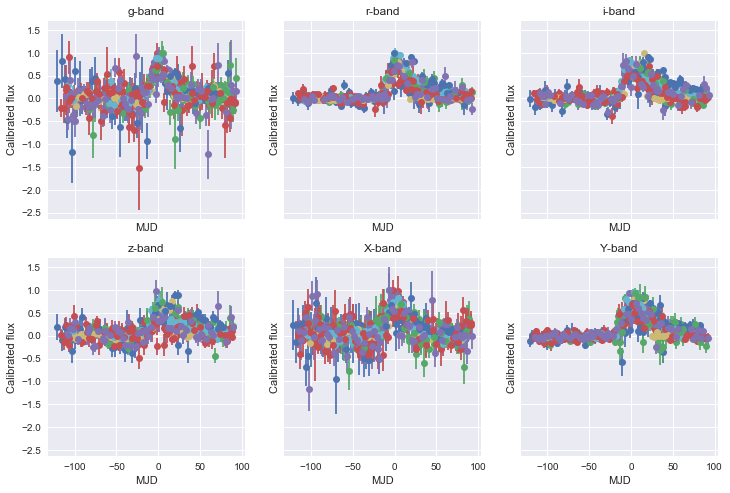

In [6]:
# set the number of light curves to plot
nplots = 10

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(nplots):
    plot_lightcurves(i, X)

Here is a dictionary to keep track of how the numeric SIM_NON1a keys in the X.iloc headers correspond to actual SN types

In [7]:
noniadict = {402:'IIb',403:'IIb',502:'Ia-91bg',
            503:'Ia-91bg',506:'Ia-91bg',509:'Ia-91bg',
            601:'IIb',602:'IIb',603:'IIb',
            604:'IIP',605:'IIP',606:'IIP',
            607:'IIn',608:'IIn',609:'IIn',
            610:'Ib',611:'Ib',612:'Ic',
            613:'Ic',614:'Ia',615:'Ia',
            616:'Iax',617:'Ia',618:'Ia',
            619:'Ia',620:'SLSN',621:'TDe'}

Now we can plot just the SNe Ia

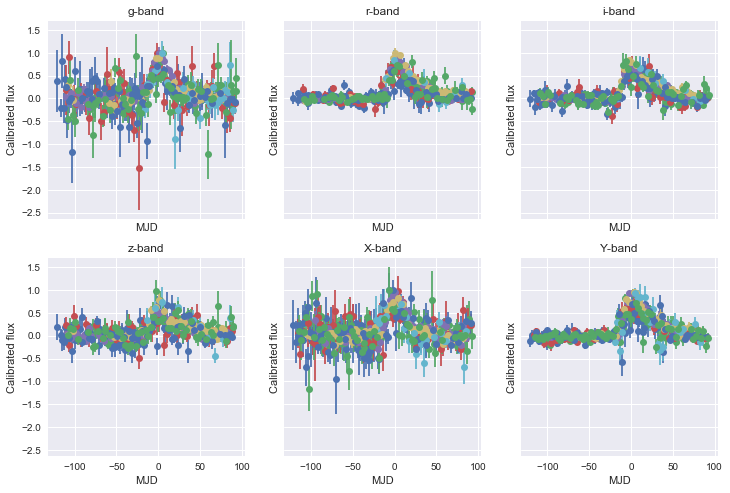

In [11]:
# set the number of light curves to plot
nplots = 10

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
for i in range(nplots):
    if X.iloc[i]['SIM_NON1a'] in noniadict.keys() and noniadict[X.iloc[i]['SIM_NON1a']] == 'Ia':
        plot_lightcurves(i, X)

# Find the Young Stuff 

Here's an example that gets a count of all the young SNe Ia discovered by the YSE survey

In [28]:
YoungCount = 0
for i in range(len(X.snid)):
    if X.iloc[i]['z'] > 0.1: continue # none of the high-z things are going to be young, probably
    if X.iloc[i]['SIM_NON1a'] == 0: continue # weeds out things from the nominal SALT2 model.  Those might not have good early LCs.
    sn = X.iloc[i]
    iYoung_g = np.where((sn['days_from_explosion_g'] >= 0) & (sn['days_from_explosion_g'] < 2) &
                       (sn['fluxcal_g']/sn['fluxcalerr_g'] > 5))[0]
    YoungCount += len(iYoung_g)
print('%i Supernovae Detected by YSE in g when they were less than 2 days old'%YoungCount)

171 Supernovae Detected by YSE in g when they were less than 2 days old
